In [1]:
import importlib

import dataset, metrics, plotting, config, network
from models import cgan_model
import numpy as np
import random

importlib.reload(network)
importlib.reload(dataset)
importlib.reload(metrics)
importlib.reload(plotting)
importlib.reload(config)
importlib.reload(cgan_model)

Using TensorFlow backend.
/Users/zhongsheng/anaconda2/envs/ganRegression/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zhongsheng/anaconda2/envs/ganRegression/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zhongsheng/anaconda2/envs/ganRegression/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

<module 'models.cgan_model' from '/Users/zhongsheng/Documents/GitWorkspace/ganRegression/models/cgan_model.py'>

In [2]:
import os

dataset_config = config.DatasetConfig(scenario="hdpe")

assert(dataset_config.scenario == "magical_sinus"
      or dataset_config.scenario == "hdpe")
fig_dir = f"../figures/{dataset_config.scenario}"

try:
    os.mkdir(fig_dir)
    print(f"Directory {fig_dir} created ")
except FileExistsError:
    print(f"Directory {fig_dir} already exists replacing files in this notebook")

Directory ../figures/hdpe already exists replacing files in this notebook


In [3]:
exp_config = config.Config(
    model=config.ModelConfig(activation="elu", lr_gen=0.0001, lr_disc=0.0001,
                             optim_gen="Adam", optim_disc="Adam", z_input_size=5),
    training=config.TrainingConfig(n_epochs=10000, batch_size=100, n_samples=500),
    dataset=dataset_config,
    run=config.RunConfig(save_fig=1)
)

In [4]:
# Set random seed
np.random.seed(exp_config.model.random_seed)
random.seed(exp_config.model.random_seed)

from tensorflow import set_random_seed
set_random_seed(exp_config.model.random_seed)

In [5]:
X_train, y_train, X_valid, y_valid = dataset.get_dataset(scenario=exp_config.dataset.scenario,
                                                                         seed=exp_config.model.random_seed)

In [6]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_valid_scaled = X_scaler.transform(X_valid)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_valid_scaled = y_scaler.transform(y_valid.reshape(-1, 1))

## Gaussian Process

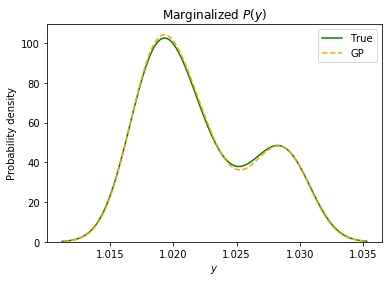

In [14]:
import GPy


variance = 0.1
length = 1

kernel = GPy.kern.RBF(input_dim=15, variance=variance, lengthscale=length)
gpr = GPy.models.GPRegression(X_train_scaled, y_train_scaled, kernel)

run_hyperopt_search = True
if run_hyperopt_search:
    gpr.optimize(messages=True)
ypred_gp_val, cov = gpr.predict(X_valid_scaled)
plotting.plot_densities_joint(y_valid, None, None, y_scaler.inverse_transform(ypred_gp_val),
                             title=f"Marginalized $P(y)$", fig_dir=fig_dir,
                             prefix="marginalized_P(y)", save_fig=exp_config.run.save_fig)

##  CGAN

In [ ]:
cgan = cgan_model.CGAN(exp_config)
d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true = cgan.train(X_train_scaled, y_train_scaled,
                                                                              epochs=exp_config.training.n_epochs,
                                                                              batch_size=exp_config.training.batch_size,
                                                                              verbose=False)

In [ ]:
ypred_single_cgan_val = cgan.predict(X_valid_scaled)

In [ ]:
ypred_mean_cgan_val, _, _ = cgan.sample(X_valid_scaled, exp_config.training.n_samples)

In [ ]:
ypred_gp_val = y_scaler.inverse_transform(ypred_gp_val)
ypred_single_cgan_val = y_scaler.inverse_transform(ypred_single_cgan_val)
ypred_mean_cgan_val = y_scaler.inverse_transform(ypred_mean_cgan_val)

In [ ]:
plotting.plots(d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true, fig_dir, exp_config.run.save_fig)

## Predictions

In [ ]:
plotting.plot_densities_joint(y_valid, ypred_single_cgan_val, ypred_mean_cgan_val, ypred_gp_val,
                             title=f"Marginalized $P(y)$", fig_dir=fig_dir,
                             prefix="marginalized_P(y)", save_fig=exp_config.run.save_fig)

In [ ]:
plotting.plot_ypred_error(y_valid, ypred_single_cgan_val, ypred_mean_cgan_val, ypred_gp_val,
                          fig_dir=fig_dir, prefix="single_mean_cgan_gp", save_fig=exp_config.run.save_fig)

## Metrics on validation samples

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

single_cgan_mae_list = []
single_cgan_mse_list= []

mean_cgan_mae_list = []
mean_cgan_mse_list = []

gp_mae_list = []
gp_mse_list =[]

n_eval_runs = 50
for i in range(n_eval_runs):
    ypred_single_cgan = cgan.predict(X_valid_scaled)
    single_cgan_mae_list.append(mean_absolute_error(y_valid, y_scaler.inverse_transform(ypred_single_cgan)))
    single_cgan_mse_list.append(mean_squared_error(y_valid, y_scaler.inverse_transform(ypred_single_cgan)))

    ypred_mean_cgan, _, _ = cgan.sample(X_valid_scaled, exp_config.training.n_samples)
    mean_cgan_mae_list.append(mean_absolute_error(y_valid, y_scaler.inverse_transform(ypred_mean_cgan)))
    mean_cgan_mse_list.append(mean_squared_error(y_valid, y_scaler.inverse_transform(ypred_mean_cgan)))

    y_pred_gp, cov = gpr.predict(X_valid_scaled)
    yped_gp = np.random.normal(y_pred_gp, np.sqrt(cov))
    gp_mae_list.append(mean_absolute_error(y_valid, y_scaler.inverse_transform(yped_gp)))
    gp_mse_list.append(mean_squared_error(y_valid, y_scaler.inverse_transform(yped_gp)))

In [ ]:
single_cgan_mae_mean, single_cgan_mae_std = np.mean(np.asarray(single_cgan_mae_list)), np.std(np.asarray(single_cgan_mae_list))
single_cgan_mse_mean, single_cgan_mse_std = np.mean(np.asarray(single_cgan_mse_list)), np.std(np.asarray(single_cgan_mse_list))

print(f"Single CGAN validation MAE: {single_cgan_mae_mean:.3e} +- {single_cgan_mae_std:.5e}")
print(f"Single CGAN validation MSE: {single_cgan_mse_mean:.3e} +- {single_cgan_mse_std:.5e}")

mean_cgan_mae_mean, mean_cgan_mae_std = np.mean(np.asarray(mean_cgan_mae_list)), np.std(np.asarray(mean_cgan_mae_list))
mean_cgan_mse_mean, mean_cgan_mse_std = np.mean(np.asarray(mean_cgan_mse_list)), np.std(np.asarray(mean_cgan_mse_list))

print(f"Mean CGAN validation MAE: {mean_cgan_mae_mean:.3e} +- {mean_cgan_mae_std:.5e}")
print(f"Mean CGAN validation MSE: {mean_cgan_mse_mean:.3e} +- {mean_cgan_mse_std:.5e}")

gp_mae_mean, gp_mae_std = np.mean(np.asarray(gp_mae_list)), np.std(np.asarray(gp_mae_list))
gp_mse_mean, gp_mse_std = np.mean(np.asarray(gp_mse_list)), np.std(np.asarray(gp_mse_list))
print(f"GP validation MAE: {gp_mae_mean:.3e} +- {gp_mae_std:.5e}")
print(f"GP validation MSE: {gp_mse_mean:.3e} +- {gp_mse_std:.5e}")

In [ ]:
nlpd_list = []
for i in range(n_eval_runs):
    y_pred_gp, cov = gpr.predict(X_valid_scaled)
    nlpd_list.append(metrics.gaussian_NLPD(y_valid,
                                           np.random.normal(y_scaler.inverse_transform(ypred_gp_val), np.sqrt(cov)),
                                           cov))
gp_nlpd_mean = np.mean(nlpd_list)
gp_nlpd_std = np.std(nlpd_list)
print(f"GP validation NLPD: {gp_nlpd_mean:.3f} +- {gp_nlpd_std:.5f}")

In [ ]:
nlpd_list = []
for i in range(n_eval_runs):
    ypred_single_cgan = cgan.predict(X_valid_scaled)
    cov = np.ones(len(ypred_single_cgan))* np.mean((y_valid - y_scaler.inverse_transform(ypred_single_cgan))**2)
    nlpd_list.append(metrics.gaussian_NLPD(y_valid, y_scaler.inverse_transform(ypred_single_cgan), cov))
single_cgan_nlpd_mean = np.mean(nlpd_list)
single_cgan_nlpd_std = np.std(nlpd_list)
print(f"Single CGAN Validation NLPD: {single_cgan_nlpd_mean:.3f} +- {single_cgan_nlpd_std:.5f}")

In [ ]:
_, w, _ = metrics.Parzen(cgan, X_valid_scaled, y_valid_scaled)
nlpd_list = []
for i in range(n_eval_runs):
    nlpd_list.append(metrics.Parzen_test(cgan, X_valid_scaled, y_valid_scaled, 0.01, exp_config.training.n_samples))
mean_cgan_nlpd_mean = np.mean(nlpd_list)
mean_cgan_nlpd_std = np.std(nlpd_list)
print(f"Mean CGAN Validation NLPD: {mean_cgan_nlpd_mean:.3f} +- {mean_cgan_nlpd_std:.5f}")

In [ ]:
if exp_config.run.save_fig:

    try:
        file = open(f"{fig_dir}/metrics_on_hdpe.txt","w")
    except FileExistsError:
        print(f" {fig_dir} was failed to create.")

    file.write(f"===Validation MAE===\n")
    file.write(f"GP validation MAE: {gp_mae_mean} +- {gp_mae_std}\n")
    file.write(f"Single CGAN validation MAE: {single_cgan_mae_mean} +- {single_cgan_mae_std}\n")
    file.write(f"Mean CGAN validation MAE: {mean_cgan_mae_mean} +- {mean_cgan_mae_std}\n")
    file.write(f"===Validation MSE===\n")
    file.write(f"GP validation MSE: {gp_mse_mean} +- {gp_mse_std}\n")
    file.write(f"Single CGAN validation MSE: {single_cgan_mse_mean} +- {single_cgan_mse_std}\n")
    file.write(f"CGAN validation MSE: {mean_cgan_mse_mean} +- {mean_cgan_mse_std}\n")
    file.write(f"===Validation NLPD===\n")
    file.write(f"GP Gaussian NLPD: {gp_nlpd_mean} +- {gp_nlpd_std}\n")
    file.write(f"Single CGAN NLPD: {single_cgan_nlpd_mean} +- {single_cgan_nlpd_std}\n")
    file.write(f"Mean CGAN NLPD: {mean_cgan_nlpd_mean} +- {mean_cgan_nlpd_std}\n")
    file.close()